## Assignment 3: Evaluation of Deep Learning Models on Image Classification

### CS 597: Special Topics on Deep Learning

### Adam Torek

### Professor: Jun Zhuang

### Spring 2025 Semester

### Library Imports/Setup

<hr>

In [195]:
# import pytorch models for evaluation
import torch
from torchvision.models import resnet50, swin_t, mobilenet_v3_large
from torchvision.models import ResNet50_Weights, Swin_T_Weights, MobileNet_V3_Large_Weights
# Import CIFAR10 Dataset for evaluation
from torchvision.datasets import CIFAR10
# Import Dataset and DataLoader libraries to make dataset management easier
from torch.utils.data import DataLoader, Dataset
# Import random transforms and normalizers to make image augmentation easier
from torchvision.transforms import RandomHorizontalFlip, Normalize, ToTensor, Compose, RandomRotation
# import tadaqum for monitoring training progress
import tqdm

# Import numpy and matplotlib to help with evaluations
import numpy as np 
import matplotlib.pyplot as plt
# Import metrics for binary image classification evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay

In [196]:
# Set hyperparameter constants during training to make model evaluation more fair
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

### Model Setup

<hr>

In [215]:
# Set up model initializers and weights that will be used as backbones for binary fine-tuning
MODEL_MAP = {
    "MobileNet-V3-Large": mobilenet_v3_large,
    "Swin-Tiny": swin_t,
    "ResNet-50": resnet50,
}

MODEL_WEIGHTS_MAP = {
    "MobileNet-V3-Large": MobileNet_V3_Large_Weights.DEFAULT,
    "Swin-Tiny": Swin_T_Weights.DEFAULT,
    "ResNet-50": ResNet50_Weights.DEFAULT,
}

In [223]:

class BinaryImageClassifier(torch.nn.Module):
    """PyTorch wrapper model that adds a simple binary classification head
    and final softmax activation on top of a given base model."""
    def __init__(self, base_model, base_model_name):
        super().__init__()
        # Set up base image classification model for evaluation
        self.base_model = base_model
        self.base_model_name = base_model_name
        # Get the number of dimensions of the last layer of the base model
        # for the binary classification head
        last_layer_features = None
        if base_model_name == "MobileNet-V3-Large":
            last_layer_features = base_model.classifier[-1].out_features
        else:
            last_layer_features = list(base_model.children())[-1].out_features
        # Set up the binary classification head projection
        self.classifier_layer = torch.nn.Linear(in_features=last_layer_features, out_features=2)
        # Use softmax to turn the projected values into a probability distribution over both classes
        self.softmax_activation = torch.nn.Softmax(dim=1)
        # Disable the gradients of the base model (not really needed for training)
        self.base_model.requires_grad_(False)

    def forward(self, x):
        # Get outputs from the base image classifier
        sub_model_outputs = self.base_model(x)
        # Project the outputs from the base model down to two values
        classifier_predictions = self.classifier_layer(sub_model_outputs)
        # Use softmax to convert final outputs into probability values
        softmax_predictions = self.softmax_activation(classifier_predictions)
        return softmax_predictions

In [224]:
def build_model(model_name, learning_rate):
    """Helper function to construct a binary image classifier from a given base model name 
    and also construct its associated AdamW optimizer with a specific learning rate."""
    # Construct the binary image classifier given a specific model name
    # Also initialize the model with pretrained weights to increase accuracy
    constructed_model = BinaryImageClassifier(MODEL_MAP[model_name](weights=MODEL_WEIGHTS_MAP[model_name]), model_name)
    # Build the optimizer that will push the classification head's weights along the gradient
    optimizer = torch.optim.AdamW(constructed_model.parameters(), lr=learning_rate)
    # Return the constructed base model with binary classification head and associated optimizer
    return (constructed_model, optimizer)

### Dataset Setup

<hr>

In [225]:
class CIFARBinaryDataSet(Dataset):
    """Helper Dataset that converts CIFAR10 into a binary dataset by only using 
    the first two image labels of the dataset. This allows for easy conversion of 
    CIFAR10 from a multi-label classification task into a binary one, making it easy
    to calculate precision, recall, f1-score, and ROC-AUC score."""
    def __init__(self, dataset_tuples, transforms=None):
        # Initialize the dataset and specific transforms for image 
        # augmentation (only used if dataset is for training)
        self.dataset_tuples = dataset_tuples
        self.transforms = transforms
        self.dataset_len = len(dataset_tuples)
        self.tensor_transform = ToTensor()

    def __len__(self):
        # Return the total length of the dataset
        return self.dataset_len
    
    def __getitem__(self, idx):
        """Helper function used to retrieve a specific image-label pair
        from the binary image classification task."""
        # Extract the image and label
        dataset_item = self.dataset_tuples[idx]
        image = self.tensor_transform(dataset_item[0])
        
        # Convert the label from a binary one into a one-hot label
        labels = [0,0]
        labels[dataset_item[1]] = 1
        # apply transforms if they are valid
        if self.transforms:
            image = self.transforms(image)
        
        # Return the image and label pair in a dictionary for easy retrieval later
        return {"image": image, "label": torch.tensor(labels, dtype=torch.float)}  

In [226]:
def construct_cifar_dataloader(batch_size, is_train=True):
    """Helper function used for building a PyTorch DataLoader
    that contains only the first two labels of the CIFAR10 dataset
    for binary classification. Can construct a dataloader for the training
    or test set of CIFAR10. Note: Image transforms are not applied for the test set."""
    # Build the total CIFAR10 dataset for extracting the first two image classes
    cifar_dataset = CIFAR10(download=True, root="data", train=is_train)
    cifar_binary_data = []
    cifar_extraction_dataloader = iter(cifar_dataset)

    #Extract only the first two labeled images for use
    for image, label in cifar_extraction_dataloader:
        if label == 0 or label == 1:
            cifar_binary_data.append((image, label))

    # Apply image transforms for augmentation if used for training models
    augmentation_transforms = None
    if is_train:
        augmentation_transforms = Compose([RandomHorizontalFlip(), RandomRotation(degrees=0.02), Normalize(mean=0, std=1)])

    # Construct the CIFAR binary dataset and dataloaders with the given batch size
    cifar_binary_dataset = CIFARBinaryDataSet(dataset_tuples=cifar_binary_data, transforms=augmentation_transforms)
    cifar_binary_dataloader = DataLoader(cifar_binary_dataset, batch_size=batch_size, shuffle=False)

    # return the data loader constructed from the CIFAR100 binary dataset
    return cifar_binary_dataloader

In [227]:
# Build the test and train dataloaders
cifar_binary_train_dataloader = construct_cifar_dataloader(batch_size=batch_size, is_train=True)
cifar_binary_test_dataloader = construct_cifar_dataloader(batch_size=batch_size, is_train=False)

Files already downloaded and verified
Files already downloaded and verified


### Model Training

<hr>

In [228]:
def train_model(model, model_name, num_epochs, optimizer, dataloader, loss_func, device):
    """Helper function used for training a specific binary image classifier model 
    for a specific number of epochs. This function requires the model's name for logging,
    optimizer for training, initialized model weights, the loss function to be used, and
    the PyTorch device that will be used for training."""
    # Move the model to the appropriate PyTorch device
    model = model.to(device)
    # Train the model for n total epochs
    for epoch in range(num_epochs):
        # Log the average loss over all of the batches
        total_batch_loss = 0
        # Create the training loop for each epoch
        training_loop = tqdm.tqdm(dataloader, leave=False)
        # Iterate over each batch of data in the training loop for M total iterations
        for batch in training_loop:
            # Zero out the gradient to prevent over-accumulation
            optimizer.zero_grad()
            # Extract the images and labels from the batch and move them to the model's device
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            # Get the binary outputs from the model
            outputs = model(images)
            
            # Apply the loss function using the ground truth labels
            # against the predictions to get the loss and adjust the gradient
            loss = loss_func(outputs, labels)
            # Propagate the loss backward throughout the model's binary classification head
            loss.backward()
            # Use the optimizer to push the model's weights down the gradient
            optimizer.step()
            # Log the current batch loss for averaging across the epoch later
            total_batch_loss += loss.item()

            # Show the loss in the training loop
            training_loop.set_postfix(loss = loss.item())

        # Print the total average loss of the given model across all batches in the current epoch
        print("The average training loss for model {0} after epoch {1} is {2}".format(model_name, str(epoch+1), float(total_batch_loss/batch_size)))

    # Return the model's trained weights once all batches and epochs of training are completed
    return model

In [229]:
# Iterate over all three models being evaluated
trained_model_dictionary = {}
# Select a GPU if one is available else use the CPU if one is not available
device = "cuda" if torch.cuda.is_available() else "cpu"
# Iterate over all models to train and train them on the binary CIFAR dataset
for model_name in list(MODEL_MAP.keys()):
    print("Starting training for {0}".format(model_name))
    # Initialize the base model with pretrained weights 
    # For binary fine-tuning
    model_weights, model_optimizer = build_model(model_name, learning_rate=learning_rate)

    # Train the binary image classification model's head (leaving the weights untouched)
    # Using the CIFAR binary image classes.
    trained_model_weights = train_model(model_weights, 
                                        model_name=model_name,
                                        num_epochs=num_epochs, 
                                        optimizer=model_optimizer, 
                                        dataloader=cifar_binary_train_dataloader, 
                                        loss_func=torch.nn.BCELoss(),
                                        device=device)
    
    # Save the trained model weights for evaluation later
    trained_model_dictionary[model_name] = trained_model_weights

Starting training for MobileNet-V3-Large


The average training loss for model MobileNet-V3-Large after epoch 1 is 10.142789752222598


The average training loss for model MobileNet-V3-Large after epoch 2 is 8.205080321989954


The average training loss for model MobileNet-V3-Large after epoch 3 is 8.169025198556483


The average training loss for model MobileNet-V3-Large after epoch 4 is 7.991138139739633


The average training loss for model MobileNet-V3-Large after epoch 5 is 7.900091324932873


The average training loss for model MobileNet-V3-Large after epoch 6 is 8.017630227841437


The average training loss for model MobileNet-V3-Large after epoch 7 is 7.855473416857421


The average training loss for model MobileNet-V3-Large after epoch 8 is 7.847528506070375


The average training loss for model MobileNet-V3-Large after epoch 9 is 7.576858174987137


The average training loss for model MobileNet-V3-Large after epoch 10 is 7.621103354729712
Starting training for Swin-Tiny


The average training loss for model Swin-Tiny after epoch 1 is 4.18337490549311


The average training loss for model Swin-Tiny after epoch 2 is 2.405785462120548


The average training loss for model Swin-Tiny after epoch 3 is 2.086466319975443


The average training loss for model Swin-Tiny after epoch 4 is 1.9480996346101165


The average training loss for model Swin-Tiny after epoch 5 is 1.8693359669996426


The average training loss for model Swin-Tiny after epoch 6 is 1.8039571658009663


The average training loss for model Swin-Tiny after epoch 7 is 1.7090406758943573


The average training loss for model Swin-Tiny after epoch 8 is 1.7236440973356366


The average training loss for model Swin-Tiny after epoch 9 is 1.7064873434137553


The average training loss for model Swin-Tiny after epoch 10 is 1.6624676160281524
Starting training for ResNet-50


The average training loss for model ResNet-50 after epoch 1 is 6.286416359245777


The average training loss for model ResNet-50 after epoch 2 is 5.614882782101631


The average training loss for model ResNet-50 after epoch 3 is 5.294210284017026


The average training loss for model ResNet-50 after epoch 4 is 5.082075017504394


The average training loss for model ResNet-50 after epoch 5 is 5.0144618935883045


The average training loss for model ResNet-50 after epoch 6 is 4.928883698768914


The average training loss for model ResNet-50 after epoch 7 is 4.836920419707894


The average training loss for model ResNet-50 after epoch 8 is 4.785890496335924


The average training loss for model ResNet-50 after epoch 9 is 4.720196035690606


The average training loss for model ResNet-50 after epoch 10 is 4.751226358115673


### Model Evaluation

<hr>

In [230]:
def evaluate_trained_model(model_name, trained_model_weights, test_dataloader, device):
    """Helper function used to evaluate the given trained CIFAR binary image classification
    model on the binary test set. This function prints the accuracy, precision, recall, f1-score,
    and AUC score as well as the ROC curve for the given model."""
    predictions = []
    labels = []
    # Get predictions from the given model by iterating 
    # over all batches in the test set
    for batch in test_dataloader:
        # Move the test images to the appropriate device
        test_images = batch["image"].to(device)
        # Gather the binary ground truth labels and 
        # convert them from one-hot encoded labels back
        # into label form
        test_labels = batch["label"]
        test_labels = torch.argmax(test_labels, dim=1)
        # Save the results to a Python list for evaluation
        for label in test_labels.tolist():
            labels.append(label)

        # Get the trained model's predictions and convert them
        # from one-hot predictions into labels
        test_predictions = trained_model_weights(test_images)
        test_predictions = torch.argmax(test_predictions, dim=1)

        # Save the model's predictions to a Python list for evaluation
        for prediction in test_predictions.tolist():
            predictions.append(prediction)

    # Convert the prediction and label lists into NumPy arrays
    # for easy integration into Scikit-Learn
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Print all of the binary classification metrics for the given model
    print("Metrics for model {0}:".format(model_name))
    # Show the accuracy of the model's predictions vs the ground truth test set
    print("Accuracy: {0}".format(accuracy_score(y_true=labels, y_pred=predictions)))
    # Show the precision, recall, and f1-scores between the model's predictions and ground truth test set
    print("Precision Score: {0}".format(precision_score(y_true=labels, y_pred=predictions)))
    print("Recall Score: {0}".format(recall_score(y_true=labels, y_pred=predictions)))
    print("F1 Score: {0}".format(f1_score(y_true=labels, y_pred=predictions)))

    # Calculate the false positive rate and true positive rates of the model compared to the ground truth
    fpr, tpr, _ = roc_curve(y_true=labels, y_score=predictions)
    # Get the AUC under the false positive and true positive rate
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC graph and AUC metric for the given trained model
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).from_predictions(y_true=labels, y_pred=predictions)
    plt.title("ROC Curve for Model {0}".format(model_name))
    plt.show()

Metrics for model MobileNet-V3-Large:
Accuracy: 0.6295
Precision Score: 0.629889669007021
Recall Score: 0.628
F1 Score: 0.628943415122684


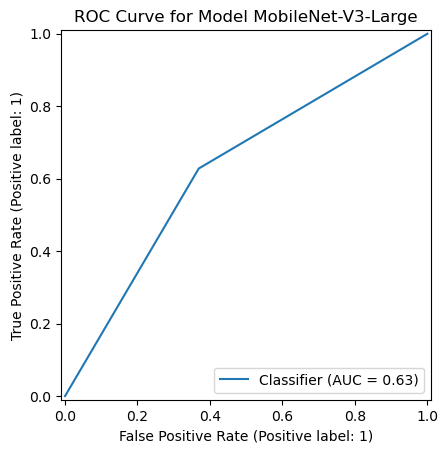

Metrics for model Swin-Tiny:
Accuracy: 0.943
Precision Score: 0.9567010309278351
Recall Score: 0.928
F1 Score: 0.9421319796954315


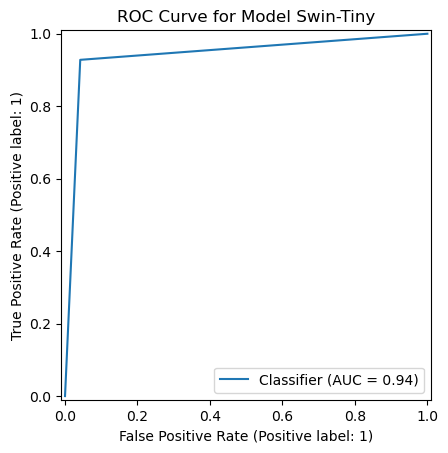

Metrics for model ResNet-50:
Accuracy: 0.762
Precision Score: 0.7712215320910973
Recall Score: 0.745
F1 Score: 0.757884028484232


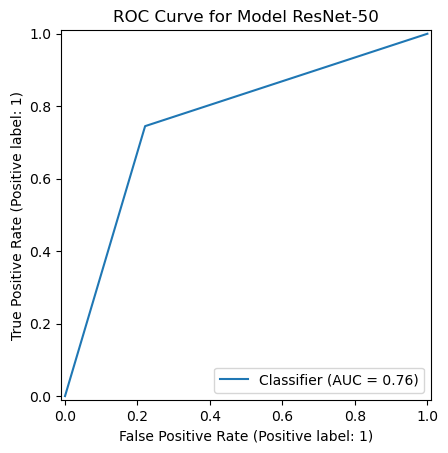

In [231]:
# Show the accuracy, precision score, recall score, F1-score, and ROC Curve for all three 
# fine-tuned binary image classifier models 
for model_name, pretrained_model_weights in trained_model_dictionary.items():
    evaluate_trained_model(model_name, pretrained_model_weights, cifar_binary_test_dataloader, device)